## 0. Import Required Packages

In [135]:
import pandas as pd
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

import warnings
warnings.filterwarnings("ignore")

## 1. Data Wrangling

In [136]:
data = pd.read_csv('./research_dataset_2022.csv', parse_dates=True, index_col=0)
# delete the rows before 1993-02-02
#data.dropna(subset=['trans_spy_open'], inplace=True)
returns = data[['trans_spy_open']]

### 1.1 Process variables referenced Hull and Qiao's research [2017]

In [137]:
var = data[['DividendToPriceRatio', 'trans_PE_RATIO', 'PxToBook', 'CAPE', 
            'bbyield', 'BAA', 'AAA', 'US3M', 'US10YR', 'Consumption_new', 
            'Assets_new', 'Income_new', 'SIM', 'trans_VIX', 'garch', 'SI',
            'IC', 'trans_BDIY', 'NOS', 'CPI', 'trans_spy_open', 'trans_SPGSCI']]
rest_data = data.drop(columns=var.columns.tolist())

In [138]:
var['DEF'] = var['BAA'] - var['AAA']
var['TERM'] = var['US10YR'] - var['US3M']

# Cointegrating Residual of Consumption, Assets, and Wealth
X = var[['Consumption_new', 'Income_new']][1800:]; Y = var['Assets_new'][1800:]
LR = LinearRegression().fit(X, Y)
residual = Y - LR.predict(X)
var['CAY'] = [np.nan] * 1800 + residual.to_list()

var['VRP'] = var['trans_VIX'] - var['garch']
var['PCR'] = var['trans_spy_open'] / var['trans_SPGSCI']
# the current price versus the past 10 month simple moving average.
var['MA'] = returns['trans_spy_open'] / returns['trans_spy_open'].rolling(217).mean()
# drop the component variables
var = var.drop(columns=['BAA', 'AAA', 'US10YR', 'US3M', 'trans_VIX', 'garch', 
                        'trans_spy_open', 'trans_SPGSCI', 'Consumption_new', 
                        'Income_new', 'Assets_new'])
var.rename(columns = {'DividendToPriceRatio':'DP', 'trans_PE_RATIO':'PE',
                      'PxToBook':'BM', 'bbyield':'BY', 'trans_BDIY':'BDI'}, inplace = True)

### 1.3 Detect the correlation

<AxesSubplot:>

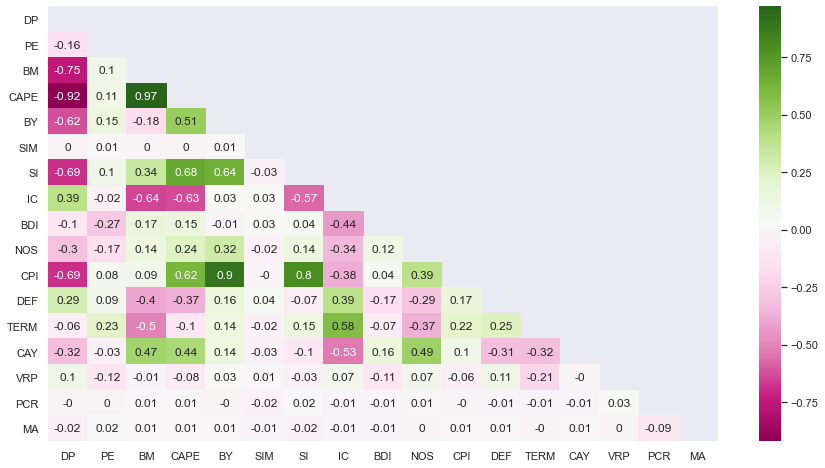

In [139]:
sn.set(rc = {'figure.figsize':(15,8)})
sn.heatmap(np.round(var.corr(), 2), mask=np.triu(np.ones_like(var.corr(), dtype=np.bool)), 
           cmap="PiYG", annot=True)

In [140]:
var['trans_VIX3M'] = rest_data['trans_VIX3M']
var[var.columns].corr()['trans_VIX3M'][:-1]

DP      0.346485
PE     -0.170715
BM     -0.121418
CAPE   -0.227073
BY      0.217709
SIM    -0.099233
SI     -0.254976
IC      0.102689
BDI    -0.053580
NOS     0.110443
CPI     0.136086
DEF     0.280805
TERM   -0.179046
CAY     0.123971
VRP     0.920611
PCR     0.019238
MA     -0.017520
Name: trans_VIX3M, dtype: float64

In [141]:
rest_corr = rest_data[rest_data.columns].corr()['trans_VIX3M']
rest_corr = rest_corr.drop(['trans_VIX3M', 'trans_VIX6M', 'trans_VIX9D', 'trans_VIX1Y'])

In [142]:
rest_corr[abs(rest_corr) > 0.1]

trans_PX_OPEN                       -0.419430
trans_PX_HIGH                       -0.406368
trans_PX_LOW                        -0.456390
trans_PX_LAST                       -0.442270
trans_PCUSEQTR                       0.367228
trans_BFCIUS                        -0.817335
advDecl                             -0.117933
FedFunds                             0.106933
trans_NYSEADV                       -0.171601
CBOE_leadIC                          0.299853
BER                                 -0.305306
vintageCPI                           0.136813
TRAIL_12M_EPS_BEF_XO_ITEM.vintage    0.137306
realVol                              0.640358
loan_corrected                       0.168686
VVIX                                 0.489550
NAPMNEWO                            -0.247240
NAPMPMI                             -0.167928
delinquency                         -0.179814
ltime                                0.193568
trans_TYVIX                          0.579219
trans_IAP                         